<a href="https://colab.research.google.com/github/X66YSH/APM466A1/blob/main/A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Q4

**Data Input**


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from scipy.interpolate import CubicSpline

bonds = [
    {"name": "CAN 1.25 Mar 25", "coupon": 0.0125, "maturity": 0.25,
     "prices": [99.73, 99.73, 99.74,  99.73, 99.74, 99.73, 99.77, 99.78,  99.80, 99.80]},
    {"name": "CAN 2.25 Jun 25", "coupon": 0.0225, "maturity": 0.5,
     "prices": [99.67,  99.66,  99.66,  99.67,  99.64,  99.64,  99.64, 99.67, 99.70, 99.73]},
    {"name": "CAN 0.50 Sep 25", "coupon": 0.0050, "maturity": 0.75,
     "prices": [ 98.40,  98.41,  98.42,  98.37,  98.36,  98.36,  98.40,  98.47,  98.50,  98.53]},
    {"name": "CAN 0.25 Mar 26", "coupon": 0.0025, "maturity": 1.25,
     "prices": [ 96.99,  96.98,  96.97,  97.00,  96.90,  96.91,  96.80,  96.90,  97.01,  97.06]},
    {"name": "CAN 4.00 Aug 26", "coupon": 0.0400, "maturity": 1.6,
     "prices": [ 101.54,  101.57,  101.53,  101.55,  101.46,  101.32,  101.20,  101.32,  101.49, 101.50]},
    {"name": "CAN 3.25 Nov 26", "coupon": 0.0325, "maturity": 1.92,
     "prices": [100.47, 99.91, 100.42, 99.96, 99.73, 100.13, 100.06, 100.20, 100.41, 100.42]},
    {"name": "CAN 1.25 Mar 27", "coupon": 0.0125, "maturity": 2.25,
     "prices": [ 96.62,  96.59,  96.58,  96.63,  96.39,  96.28,  96.19,  96.36,  96.60,  96.64]},
    {"name": "CAN 2.75 Sep 27", "coupon": 0.0275, "maturity": 2.67,
     "prices": [99.63, 99.56, 99.54, 99.58, 99.27, 99.13, 99.02, 99.20, 99.50, 99.53]},
    {"name": "CAN 3.50 Mar 28", "coupon": 0.0350, "maturity": 3.25,
     "prices": [101.82, 101.70, 101.72, 101.52, 101.26, 101.02, 101.24, 101.58, 101.65, 101.70]},
    {"name": "CAN 2.25 Dec 29", "coupon": 0.0225, "maturity": 4.90,
     "prices": [ 96.60,  96.63,  96.42,  96.25,  95.77,  95.38,  95.65,  96.22,  96.35,  96.51]}
]


face = 100
freq = 2


maturities = [bond["maturity"] for bond in bonds]



**YTM Calculation and Plot**

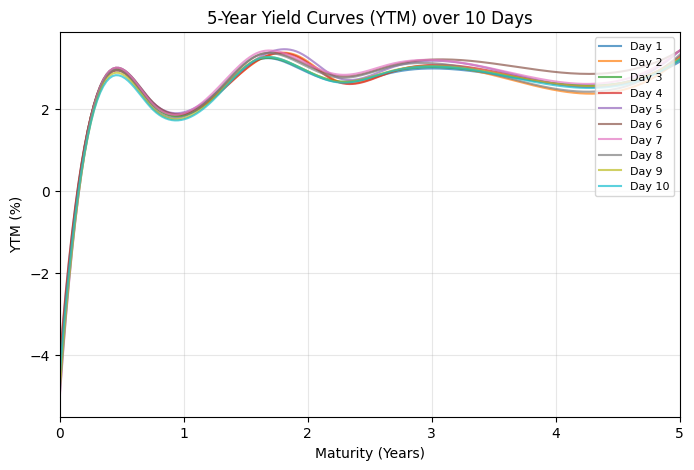

In [34]:
import math

def calculate_ytm(price, coupon, maturity, face=100, freq=2):
    N = math.ceil(maturity * freq)
    coupon_pmt = coupon * face / freq
    def f(y):
        pv = sum(coupon_pmt / (1 + y/freq)**t for t in range(1, N))
        pv += (coupon_pmt + face) / (1 + y/freq)**N
        return pv - price
    return newton(f, coupon)


days = len(bonds[0]["prices"])
ytm_curves = []
for day in range(days):
    daily_ytms = []
    for bond in bonds:
        price = bond["prices"][day]
        ytm = calculate_ytm(price, bond["coupon"], bond["maturity"], face, freq)
        daily_ytms.append(ytm)
    ytm_curves.append(daily_ytms)


plt.figure(figsize=(8,5))
x_smooth = np.linspace(0, 5, 200)
for day in range(days):
    cs = CubicSpline(maturities, np.array(ytm_curves[day])*100)
    plt.plot(x_smooth, cs(x_smooth), label=f'Day {day+1}', alpha=0.7)
plt.title('5-Year Yield Curves (YTM) over 10 Days')
plt.xlabel('Maturity (Years)')
plt.ylabel('YTM (%)')
plt.xlim(0,5)
plt.legend(fontsize=8, loc='upper right')
plt.grid(alpha=0.3)
plt.show()

**Spot Rate**

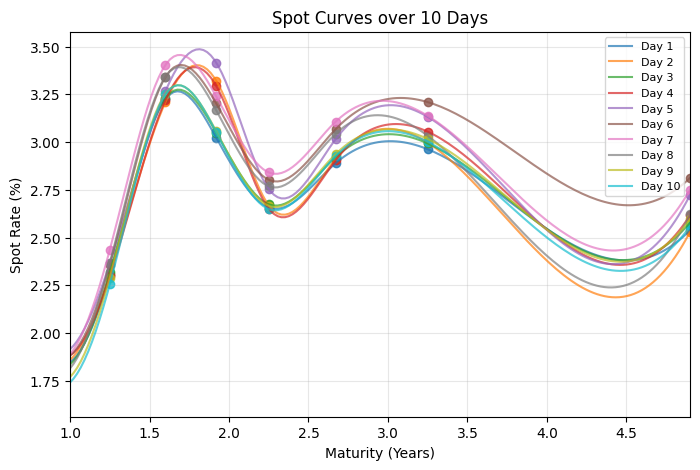

In [41]:
def bootstrap_spot_curve(bonds, day_index, face=100, freq=2):
    # Assume bonds are sorted in ascending order by maturity
    discount_factors = {}  # key: period t, value: discount factor D(t)
    spot_rates = {}        # key: maturity (years), value: spot rate (annualized, decimal)
    for bond in sorted(bonds, key=lambda b: b["maturity"]):
        price = bond["prices"][day_index]
        coupon = bond["coupon"]
        maturity = bond["maturity"]
        N = math.ceil(maturity * freq)  # number of periods
        coupon_pmt = coupon * face / freq
        pv_coupons = 0
        for t in range(1, N):
            if t in discount_factors:
                pv_coupons += coupon_pmt * discount_factors[t]
        D_N = (price - pv_coupons) / (coupon_pmt + face)
        discount_factors[N] = D_N
        # For semiannual compounding: D(N) = 1/(1+s/2)^N  => s = 2*((1/D_N)^(1/N) - 1)
        s = 2 * ((1 / D_N)**(1 / N) - 1)
        spot_rates[maturity] = s
    return spot_rates

# Compute spot curves for each day
spot_curves = []
for day in range(days):
    spots = bootstrap_spot_curve(bonds, day, face, freq)
    spot_curves.append(spots)

# Plot the 5-year spot curves for each day
plt.figure(figsize=(8, 5))
for day, spots in enumerate(spot_curves):
    xs = sorted(spots.keys())
    ys = [spots[m] * 100 for m in xs]  # convert to percentage
    cs = CubicSpline(xs, ys)
    x_smooth = np.linspace(min(xs), max(xs), 200)
    plt.plot(x_smooth, cs(x_smooth), label=f'Day {day + 1}', alpha=0.7)
    plt.scatter(xs, ys, alpha=0.8)
plt.title('Spot Curves over 10 Days')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rate (%)')
plt.xlim(1, max(maturities))
plt.legend(fontsize=8, loc='upper right')
plt.grid(alpha=0.3)
plt.show()


**Forward Rate**

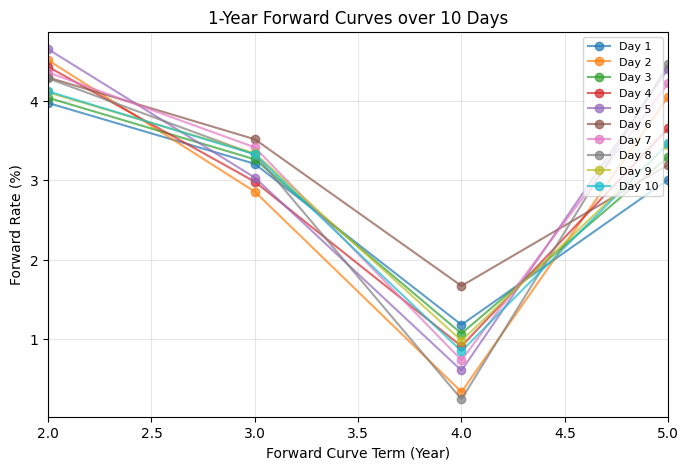

In [40]:
def calculate_forward_rates(spot_dict):
    # Extract integer-year spot rates; if missing, use interpolation
    required = [1.0, 2.0, 3.0, 4.0, 5.0]
    S = {}
    for t in required:
        if t in spot_dict:
            S[t] = spot_dict[t]
    forward = {}
    # For t = 1,...,4 compute the 1-year forward rate:
    # f_t = ((1+S(t+1))^(t+1) / (1+S(t))^t) - 1
    for t in sorted(S.keys())[:-1]:
        fwd = ((1 + S[t + 1])**(t + 1) / (1 + S[t])**t) - 1
        forward[t] = fwd
    return forward

# Compute forward curves for each day
forward_curves = []
for day in range(days):
    spots = spot_curves[day]
    # Interpolate to get spot rates at integer maturities
    xs = sorted(spots.keys())
    ys = [spots[x] for x in xs]
    cs = CubicSpline(xs, ys)
    spot_int = {}
    for t in [1.0, 2.0, 3.0, 4.0, 5.0]:
        spot_int[t] = cs(t)
    fwd = calculate_forward_rates(spot_int)
    forward_curves.append(fwd)

# Plot the 1-year forward curves for each day (x-axis: forward term ending at 2,3,4,5 years)
plt.figure(figsize=(8, 5))
for day, fwd in enumerate(forward_curves):
    xs = [t + 1 for t in sorted(fwd.keys())]  # forward ending year
    ys = [fwd[t] * 100 for t in sorted(fwd.keys())]  # convert to percentage
    plt.plot(xs, ys, marker='o', label=f'Day {day + 1}', alpha=0.7)
plt.title('1-Year Forward Curves over 10 Days')
plt.xlabel('Forward Curve Term (Year)')
plt.ylabel('Forward Rate (%)')
plt.xlim(2, 5)
plt.legend(fontsize=8, loc='upper right')
plt.grid(alpha=0.3)
plt.show()

###Q5

In [44]:
import numpy as np

# --- Part 5: Covariance Matrices ---

# 1. For yield log-returns:
# We assume that the yields for maturities 1,2,3,4,5 years are at indices [1, 3, 5, 7, 9].
yield_indices = [1, 3, 5, 7, 9]

# Construct an array of shape (days, 5), where each row is the yields for those maturities on a given day.
yield_array = np.array([
    [ytm_curves[day][i] for i in yield_indices]
    for day in range(days)
])

# Compute daily log-returns: log( r(day+1) / r(day) )
log_returns_yields = np.log(yield_array[1:, :] / yield_array[:-1, :])

# Compute the covariance matrix (5x5) of the yield log-returns.
cov_yields = np.cov(log_returns_yields, rowvar=False)
print("Covariance matrix of yield log returns:")
print(cov_yields)

# 2. For forward rate log-returns:
# Each day's forward_curves[day] is a dictionary with keys [1, 2, 3, 4] (for 1yr-1yr, 1yr-2yr, etc.)
forward_array = np.array([
    [forward_curves[day][k] for k in sorted(forward_curves[day].keys())]
    for day in range(days)
])

# Compute daily log-returns for the forward rates.
log_returns_forwards = np.log(forward_array[1:, :] / forward_array[:-1, :])

# Compute the covariance matrix (4x4) of the forward rate log-returns.
cov_forwards = np.cov(log_returns_forwards, rowvar=False)
print("\nCovariance matrix of forward rate log returns:")
print(cov_forwards)


Covariance matrix of yield log returns:
[[2.07999216e-04 2.78667265e-04 2.69484790e-04 2.71748380e-04
  2.41457863e-04]
 [2.78667265e-04 5.17277519e-04 3.54692536e-04 4.24253091e-04
  2.44514637e-04]
 [2.69484790e-04 3.54692536e-04 3.56201346e-03 2.97020873e-04
  1.22078793e-06]
 [2.71748380e-04 4.24253091e-04 2.97020873e-04 4.47672481e-04
  3.30192406e-04]
 [2.41457863e-04 2.44514637e-04 1.22078793e-06 3.30192406e-04
  5.65585820e-04]]

Covariance matrix of forward rate log returns:
[[ 0.00598636 -0.00614128 -0.05705262  0.01483667]
 [-0.00614128  0.00787728  0.06509054 -0.01591092]
 [-0.05705262  0.06509054  1.00536528 -0.2103415 ]
 [ 0.01483667 -0.01591092 -0.2103415   0.05321612]]


###Q6

In [45]:
import numpy as np

# Assume cov_yields (5x5) and cov_forwards (4x4) are the covariance matrices computed in Part 5.

# --- Eigen decomposition for the yield covariance matrix ---
eigvals_y, eigvecs_y = np.linalg.eig(cov_yields)
# Sort eigenvalues (and eigenvectors) in descending order
sort_indices_y = np.argsort(eigvals_y)[::-1]
eigvals_y = eigvals_y[sort_indices_y]
eigvecs_y = eigvecs_y[:, sort_indices_y]

print("Eigenvalues of yield covariance matrix:")
print(eigvals_y)
print("Eigenvectors of yield covariance matrix:")
print(eigvecs_y)

# Largest eigenvalue and its corresponding eigenvector
largest_eig_y = eigvals_y[0]
largest_eigvec_y = eigvecs_y[:, 0]
print("\nLargest eigenvalue of yield covariance matrix:", largest_eig_y)
print("Corresponding eigenvector:", largest_eigvec_y)

# --- Eigen decomposition for the forward rates covariance matrix ---
eigvals_f, eigvecs_f = np.linalg.eig(cov_forwards)
# Sort eigenvalues (and eigenvectors) in descending order
sort_indices_f = np.argsort(eigvals_f)[::-1]
eigvals_f = eigvals_f[sort_indices_f]
eigvecs_f = eigvecs_f[:, sort_indices_f]

print("\nEigenvalues of forward rates covariance matrix:")
print(eigvals_f)
print("Eigenvectors of forward rates covariance matrix:")
print(eigvecs_f)

largest_eig_f = eigvals_f[0]
largest_eigvec_f = eigvecs_f[:, 0]
print("\nLargest eigenvalue of forward rates covariance matrix:", largest_eig_f)
print("Corresponding eigenvector:", largest_eigvec_f)

# Explanation:
# The largest eigenvalue and its corresponding eigenvector represent the direction of maximum variance in the data.
# In interest rate data, this principal component typically reflects a parallel shift of the yield curve.


Eigenvalues of yield covariance matrix:
[3.67522676e-03 1.27047554e-03 2.93528759e-04 3.96433637e-05
 2.16740727e-05]
Eigenvectors of yield covariance matrix:
[[ 0.09857831 -0.34660213 -0.03073877  0.17365647 -0.91599554]
 [ 0.13702732 -0.51485152 -0.5787733   0.52297581  0.32812984]
 [ 0.97786866  0.18949409  0.08296252  0.00255115  0.03123426]
 [ 0.11952478 -0.53043073 -0.19712913 -0.81310285  0.06603734]
 [ 0.03150449 -0.54546321  0.78634211  0.18760857  0.21896681]]

Largest eigenvalue of yield covariance matrix: 0.0036752267558663914
Corresponding eigenvector: [0.09857831 0.13702732 0.97786866 0.11952478 0.03150449]

Eigenvalues of forward rates covariance matrix:
[1.05737842e+00 1.09627754e-02 3.48556915e-03 6.18269568e-04]
Eigenvectors of forward rates covariance matrix:
[[ 0.05617927 -0.38170563 -0.42816511 -0.81720214]
 [-0.06391222  0.36440188  0.73967405 -0.5621466 ]
 [-0.97483643 -0.21933303  0.03629777  0.01641407]
 [ 0.20604136 -0.82061264  0.51791835  0.12610485]]

Large